In [6]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

# Auxiliary Functions

In [7]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
model_LRP = vit_LRP(pretrained=True).cuda()
model_LRP.eval()
lrp = LRP(model_LRP)

def generate_visualization(original_image, class_index=None):
    grad_lrp = lrp.generate_LRP(original_image.unsqueeze(0).cuda(), method="grad", index=class_index).detach()
    grad_lrp = grad_lrp.reshape(1, 1, 14, 14)
    grad_lrp = torch.nn.functional.interpolate(grad_lrp, scale_factor=16, mode='bilinear')
    grad_lrp = grad_lrp.reshape(224, 224).cuda().data.cpu().numpy()
    grad_lrp = (grad_lrp - grad_lrp.min()) / (grad_lrp.max() - grad_lrp.min())
    image_grad_lrp = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_grad_lrp = (image_grad_lrp - image_grad_lrp.min()) / (image_grad_lrp.max() - image_grad_lrp.min())
    vis = show_cam_on_image(image_grad_lrp, grad_lrp)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

CLS2IDX = {
    243: 'bull mastiff',
    282: 'tiger cat',
    281: 'tabby, tabby cat',
    285: 'Egyptian cat',
    811: 'space heater',
    340: 'zebra',
    101: 'tusker',
    386: 'African elephant, Loxodonta africana',
    385: 'Indian elephant, Elephas maximus',
    343: 'warthog',
}

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

# Examples

## Cat-Dog

Top 5 classes:
	282 : tiger cat       		value = 10.559	 prob = 68.6%
	281 : tabby, tabby cat		value = 9.059	 prob = 15.3%
	285 : Egyptian cat    		value = 8.414	 prob = 8.0%
	243 : bull mastiff    		value = 7.425	 prob = 3.0%
	811 : space heater    		value = 5.152	 prob = 0.3%


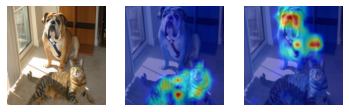

In [8]:
image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model_LRP(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

## Tusker-Zebra

Top 5 classes:
	101 : tusker                              		value = 11.216	 prob = 37.9%
	340 : zebra                               		value = 10.973	 prob = 29.7%
	386 : African elephant, Loxodonta africana		value = 10.747	 prob = 23.7%
	385 : Indian elephant, Elephas maximus    		value = 9.547	 prob = 7.2%
	343 : warthog                             		value = 5.566	 prob = 0.1%


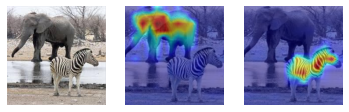

In [9]:
image = Image.open('samples/el2.png')
tusker_zebra_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model_LRP(tusker_zebra_image.unsqueeze(0).cuda())
print_top_classes(output)

# tusker - the predicted class
tusker = generate_visualization(elephant_zebra_image)

# zebra 
# generate visualization for class 340: 'zebra'
zebra = generate_visualization(elephant_zebra_image, class_index=340)


axs[1].imshow(tusker);
axs[1].axis('off');
axs[2].imshow(zebra);
axs[2].axis('off');